## Work in progress

In [21]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (14, 7)})
plt.rcParams.update({'figure.dpi': 200})

from toad_lab import TOAD, TOADPlotter

In [22]:
td = TOAD(xr.open_dataset("../testing-data/garbe_2020_antarctica.nc").coarsen(x=1, y=1, time=3, boundary='trim').mean())

In [ ]:
# shifts have been precomputed
# td.compute_shifts('thk')

The `td.compute_clusters` function accepts various clustering methods from the `toad_lab.clustering.methods` module. These methods are objects that require specific parameters for each clustering algorithm.

In [23]:
from toad_lab.clustering.methods import HDBSCAN
from toad_lab.clustering.methods import DBSCAN

# HDBSCAN (default)
td.compute_clusters('thk', 
    method=HDBSCAN(
        min_cluster_size=25,
        min_samples=5, # optional, defaults to min_cluster_size
        cluster_selection_epsilon=0.1, # optional, defauls to 0
        metric='manhattan', # optional, defaults to 'euclidean'
    ),
    shifts_filter_func=lambda x: np.abs(x) > 0.8,
    overwrite=True,
)

# DBSCAN
td.compute_clusters('thk', 
    method=DBSCAN(
        eps=0.1,
        min_samples=5,
        metric='euclidean', # optional, defaults to 'euclidean'
    ),
    shifts_filter_func=lambda x: np.abs(x) > 0.8,
    overwrite=True,
)

## Defining your own clustering method
You can also define your own clustering method by extending the `ClusteringMethod` class. 

In [20]:
from toad_lab.clustering import ClusteringMethod

class MyClusterMethod(ClusteringMethod):
    
    # required method to initialize the class
    def __init__(self, my_param):
        self.my_param = my_param

    # required method
    def apply(self, coords: np.ndarray, weights=None):
        """

        Args:
            coords (np.ndarray): A list of the coordinates to be clustered, e.g. (time, x, y)
            weights (np.ndarray, optional): Importance weights for each data point. 

        Returns:
            tuple: A tuple containing:
                - np.ndarray: A 1D NumPy array of cluster labels for each data point, 
                  where -1 indicates unclustered points.
                - dict: A dictionary summarizing the HDBSCAN parameters used, suitable 
                  for storing as metadata or documentation.
        """
        
        
        cluster_labels_array = ... # your clustering algorithm here

        # Return method details to be saved as attr
        method_details = {
            "method": "my_cluster_method",
            "params": {
                "my_param": self.my_param,
            },
        }

        return cluster_labels_array, method_details
    

# then to apply
td.compute_clusters('thk', 
    method=MyClusterMethod(
        my_param=(1, 2.0, 2.0), # time, x, y thresholds
    ),
    shifts_filter_func=lambda x: np.abs(x) > 0.8,
    overwrite=True,
)

Example of a custom clustering method:

In [17]:
from toad_lab.clustering import ClusteringMethod

class MyClusterMethod(ClusteringMethod):
    
    # required method to initialize the class
    def __init__(self, my_param):
        self.my_param = my_param

    # extremly crude clustering algorithm for demonstration purposes
    def crude_clustering(self, coords, txy_thresholds=(0.5, 1.0, 1.0)):
        clusters = []
        labels = []
        for point in coords:
            for i, centroid in enumerate(clusters):
                if all(abs(point - centroid) <= txy_thresholds): break
            else: clusters.append(point); i = len(clusters) - 1
            labels.append(i)
        return np.array(labels)

    # required method
    def apply(self, coords: np.ndarray, weights=None):
        """

        Args:
            coords (np.ndarray): A list of the coordinates to be clustered, e.g. (time, x, y)
            weights (np.ndarray, optional): Importance weights for each data point. 

        Returns:
            tuple: A tuple containing:
                - np.ndarray: A 1D NumPy array of cluster labels for each data point, 
                  where -1 indicates unclustered points.
                - dict: A dictionary summarizing the HDBSCAN parameters used, suitable 
                  for storing as metadata or documentation.
        """
        
        # write extremely crude clustering algorithm
        cluster_labels_array = self.crude_clustering(coords, self.my_param)

        # Metadata details
        method_details = {
            "method": "my_cluster_method",
            "params": {
                "my_param": self.my_param,
            },
        }

        return cluster_labels_array, method_details
    

td.compute_clusters('thk', 
    method=MyClusterMethod(
        my_param=(1, 2.0, 2.0), # time, x, y thresholds
    ),
    shifts_filter_func=lambda x: np.abs(x) > 0.8,
    overwrite=True,
)

{-1: 25494, 0: 1975, 1: 1212, 2: 335, 3: 447, 4: 2122, 5: 1320, 6: 928, 7: 137, 8: 2413, 9: 2428, 10: 890, 11: 35, 12: 177, 13: 1001, 14: 151, 15: 27}


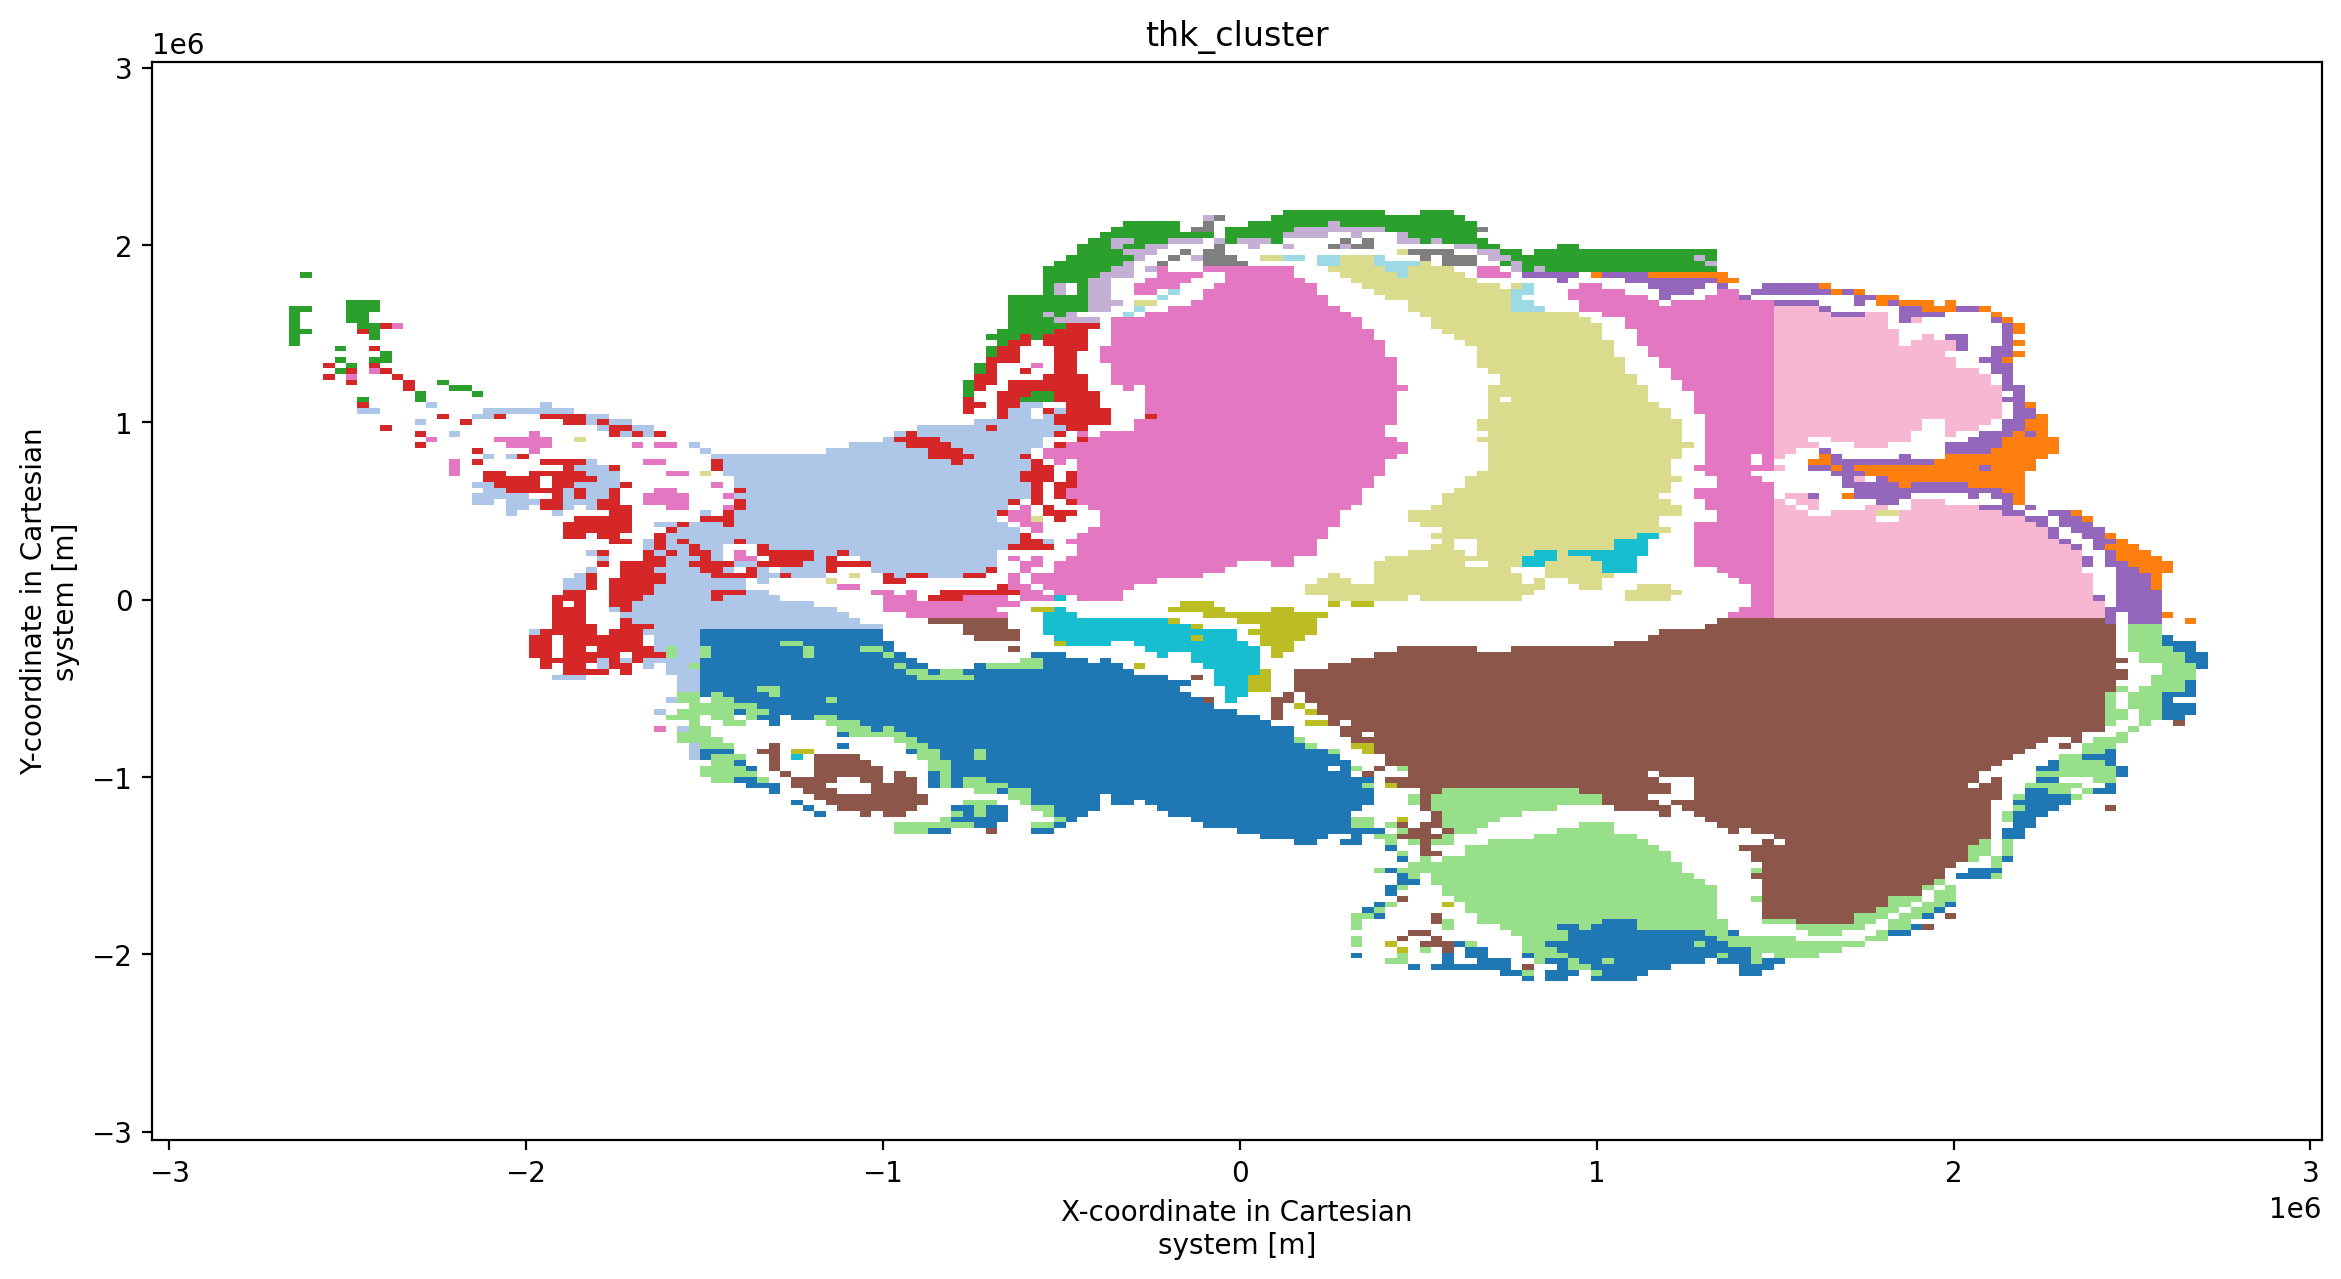

In [18]:
td.plotter().plot_clusters_on_map('thk')
print(td.get_cluster_counts("thk"))

### Clustering score
**Cluster scoring:** Values range between 0 and 1. A score of 1 indicates a cluster with a perfect Heaviside function, while a score of 0 indicates a perfect linear function. Unclustered cells (id=-1) receiving a low score is a sign of good clustering, as it suggests that these cells largely evolve linearly. The scoring is simply the rescaled slope of a linear fit.

In [5]:
from toad_lab.clustering.methods import HDBSCAN

data = xr.open_dataset("../testing-data/garbe_2020_antarctica.nc")
td = TOAD(data)

td.compute_clusters(
    var='thk',
    method=HDBSCAN(min_cluster_size=50),
    shifts_filter_func=lambda x: np.abs(x) > 0.8,
)

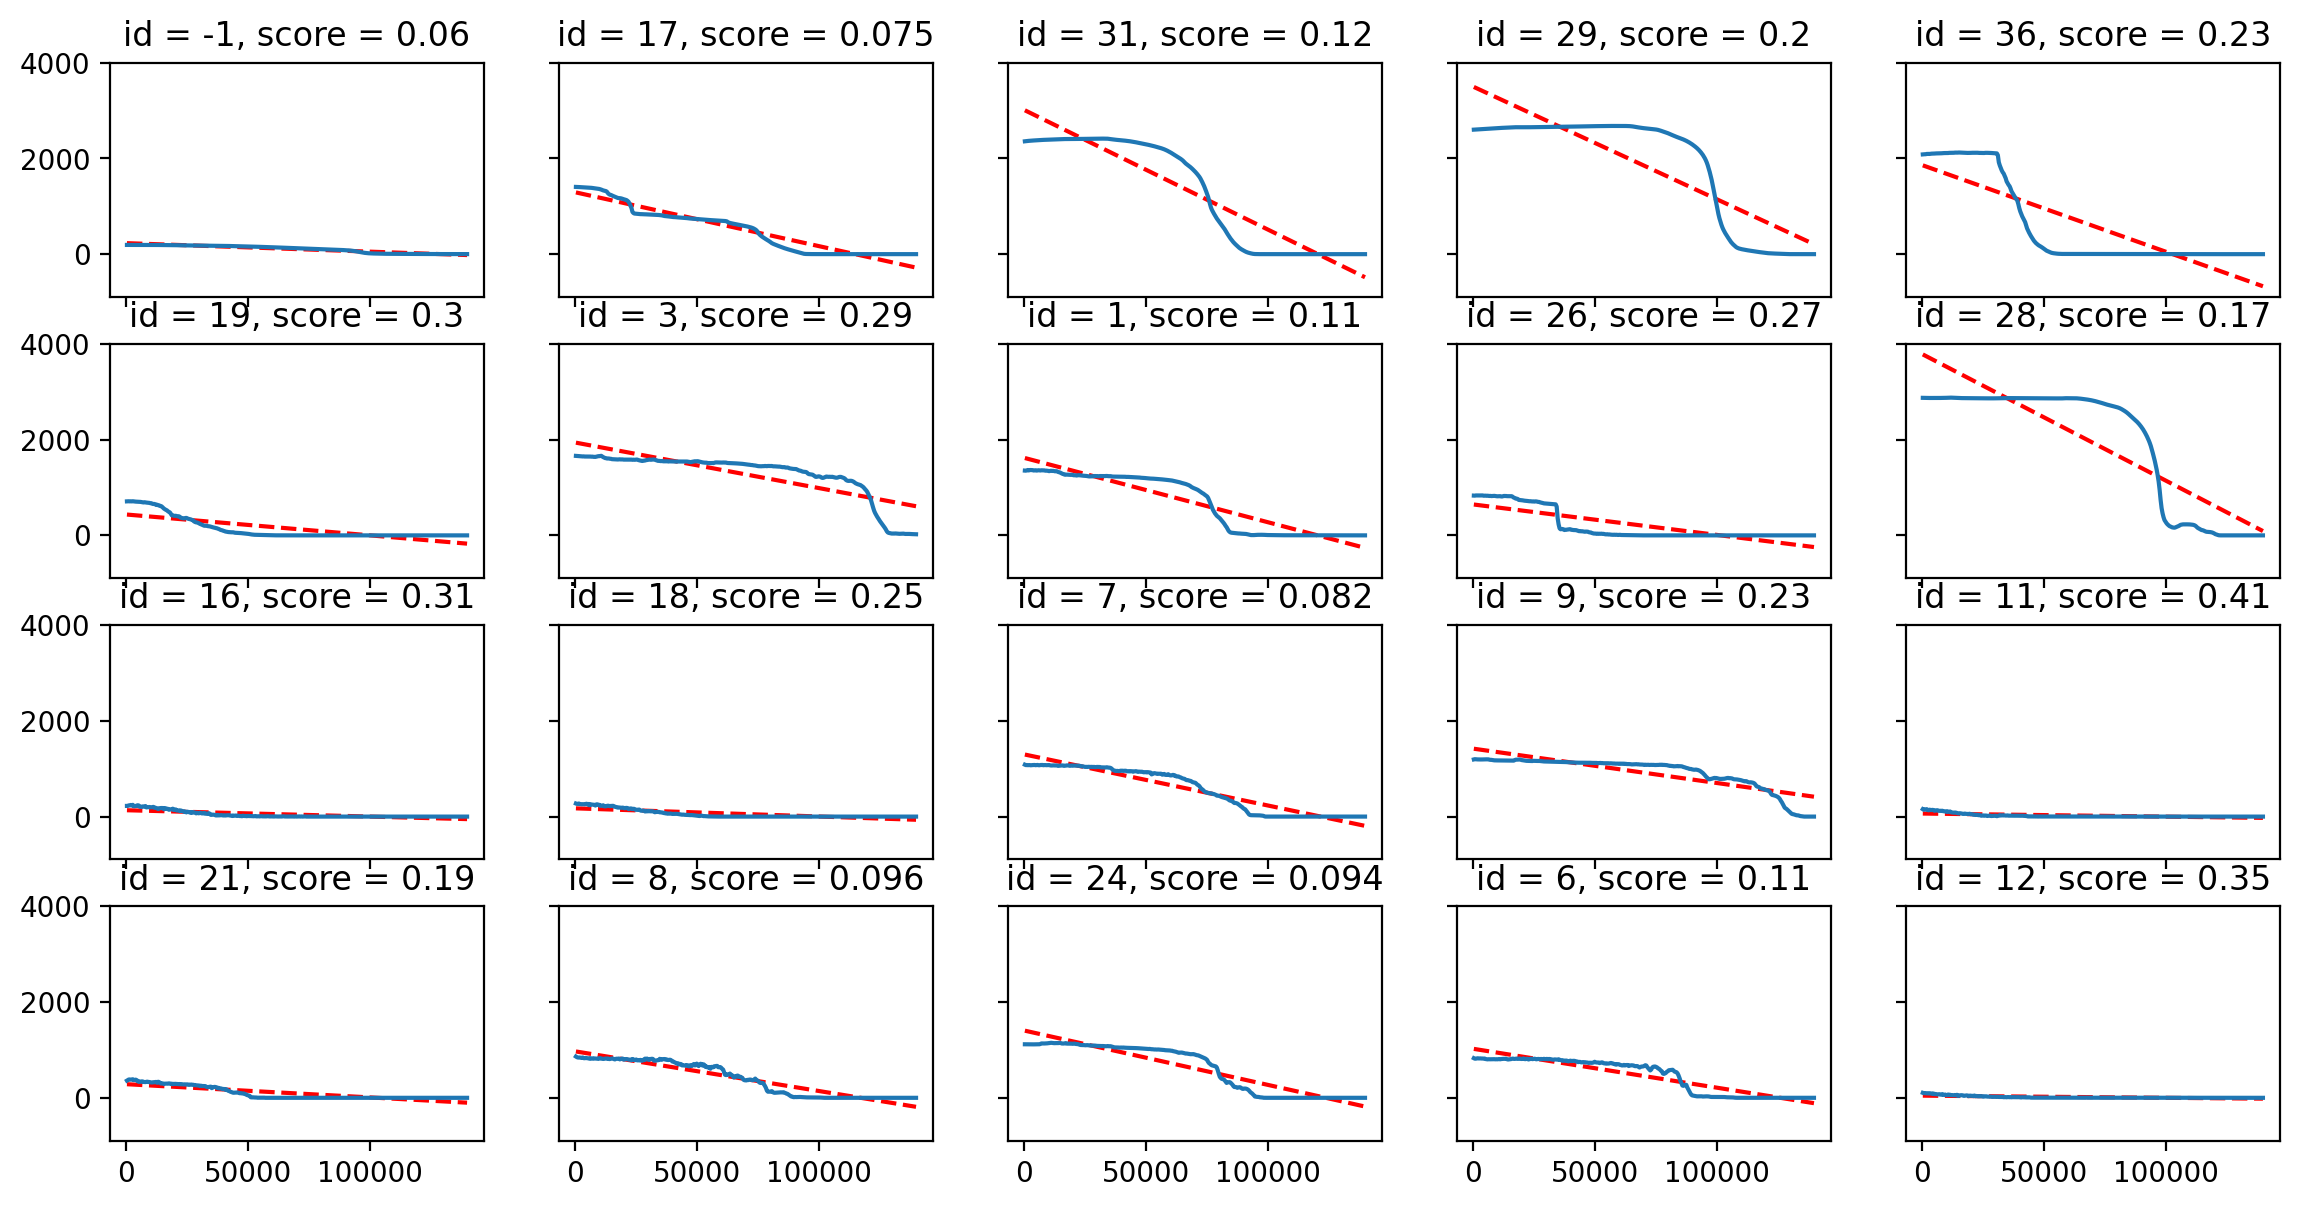

In [10]:
cluster_ids = td.get_cluster_ids('thk', sort=True)[:20]
fig, axs = plt.subplots(np.ceil(len(cluster_ids)/5).astype(int), 5, figsize=(14,7), sharex=True, sharey=True)
for i, cluster_id in enumerate(cluster_ids):    
    
    how = "mean" # or median, std, aggr. 

    ax = axs.flat[i]
    score, fit = td.stats().compute_cluster_score('thk', cluster_id, how=how, return_score_fit=True)
    ax.plot(td.data.time, fit, "--r")
    td.stats().get_cluster_cell_aggregate('thk', cluster_id, how=how)["thk"].plot(ax=ax)
    ax.set_title(f"id = {cluster_id}, score = {score:.2}", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")

# remove_ticks(axs.flat)